In [3]:
import os
import numpy as np
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split

# Define dataset path
data_path = "/kaggle/input/garbage-classification-v2/garbage-dataset"

# Define output paths for splits
out_dir = "/kaggle/working/"
train_dir = os.path.join(out_dir, "train")
valid_dir = os.path.join(out_dir, "valid")
test_dir = os.path.join(out_dir, "test")

# Create directories
for folder in [train_dir, valid_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Train-Validation-Test Split Ratios
train_ratio = 0.7  
valid_ratio = 0.15  
test_ratio = 0.15   

# Process each class
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    
    if not os.path.isdir(class_path):
        continue  

    # Get all image file names
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    # Shuffle images
    random.shuffle(image_files)
    
    # Split images
    train_imgs, temp_imgs = train_test_split(image_files, test_size=(1 - train_ratio), random_state=42)
    valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (test_ratio + valid_ratio)), random_state=42)

    # Create class directories
    for folder in [train_dir, valid_dir, test_dir]:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

    # Move images
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    
    for img in valid_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_dir, class_name, img))
    
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

# Verify classes
print("Classes:", os.listdir(train_dir))
print("Train samples:", sum([len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)]))
print("Valid samples:", sum([len(os.listdir(os.path.join(valid_dir, cls))) for cls in os.listdir(valid_dir)]))
print("Test samples:", sum([len(os.listdir(os.path.join(test_dir, cls))) for cls in os.listdir(test_dir)]))


Classes: ['shoes', 'cardboard', 'clothes', 'plastic', 'trash', 'battery', 'metal', 'glass', 'paper', 'biological']
Train samples: 13825
Valid samples: 2966
Test samples: 2971


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size for ResNet-50
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Only rescaling for validation & test sets
valid_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Print class indices
print("Class Indices:", train_generator.class_indices)


Found 13825 images belonging to 10 classes.
Found 2966 images belonging to 10 classes.
Found 2971 images belonging to 10 classes.
Class Indices: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load Pretrained ResNet-50 (without the top layer)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers to retain pretrained weights
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(10, activation="softmax")(x)  # 10 classes

# Compile the model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,773,770 (94.50 MB)

 Trainable params: 1,184,522 (4.52 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


In [11]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Stronger Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,  # Increase rotation
    width_shift_range=0.3,  # Stronger shift
    height_shift_range=0.3,  
    shear_range=0.3,  
    zoom_range=0.3,  
    horizontal_flip=True,
    vertical_flip=True,  # Include vertical flip
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Unfreeze last 100 layers (more trainable parameters)
for layer in base_model.layers[-100:]:  
    layer.trainable = True  

# Learning Rate Scheduling
lr_schedule = ExponentialDecay(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# Recompile the model with the new learning rate
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss="categorical_crossentropy", metrics=["accuracy"])

# Train Again
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=40,  
    callbacks=[early_stopping, model_checkpoint]
)


Found 13825 images belonging to 10 classes.
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


433/433 ━━━━━━━━━━━━━━━━━━━━ 240s 457ms/step - accuracy: 0.1963 - loss: 2.8007 - val_accuracy: 0.3898 - val_loss: 1.9728
Epoch 2/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 176s 401ms/step - accuracy: 0.3246 - loss: 2.2593 - val_accuracy: 0.4164 - val_loss: 1.9521
Epoch 3/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 176s 399ms/step - accuracy: 0.3843 - loss: 1.9841 - val_accuracy: 0.2967 - val_loss: 5.8744
Epoch 4/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 175s 397ms/step - accuracy: 0.4363 - loss: 1.7958 - val_accuracy: 0.4461 - val_loss: 2.1318
Epoch 5/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 176s 399ms/step - accuracy: 0.4810 - loss: 1.6257 - val_accuracy: 0.5971 - val_loss: 1.2197
Epoch 6/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 173s 391ms/step - accuracy: 0.5129 - loss: 1.4812 - val_accuracy: 0.5941 - val_loss: 1.2437
Epoch 7/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 172s 392ms/step - accuracy: 0.5633 - loss: 1.3496 - val_accuracy: 0.6382 - val_loss: 1.2278
Epoch 8/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 175s 397ms/step - accuracy: 0.5899 - loss: 1.25

In [12]:
# Train for 10 more epochs
history_finetune_2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,  # Extending 10 more epochs
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 186s 422ms/step - accuracy: 0.8900 - loss: 0.3393 - val_accuracy: 0.8715 - val_loss: 0.4152
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 189s 428ms/step - accuracy: 0.8964 - loss: 0.3169 - val_accuracy: 0.8803 - val_loss: 0.4002
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 196s 445ms/step - accuracy: 0.8939 - loss: 0.3185 - val_accuracy: 0.8877 - val_loss: 0.3818
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 192s 435ms/step - accuracy: 0.8908 - loss: 0.3237 - val_accuracy: 0.8871 - val_loss: 0.3830
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 190s 431ms/step - accuracy: 0.9067 - loss: 0.2894 - val_accuracy: 0.8904 - val_loss: 0.3697
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 186s 423ms/step - accuracy: 0.9020 - loss: 0.3012 - val_accuracy: 0.8854 - val_loss: 0.3893
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 187s 425ms/step - accuracy: 0.9103 - loss: 0.2757 - val_accuracy: 0.8857 - val_loss: 0.3905
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 182s 413ms/step - accuracy: 0.9115 -

In [13]:
# Train for 10 more epochs
history_finetune_2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  # Extending 10 more epochs
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 179s 406ms/step - accuracy: 0.9157 - loss: 0.2570 - val_accuracy: 0.8810 - val_loss: 0.4057
Epoch 2/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 193s 440ms/step - accuracy: 0.9177 - loss: 0.2547 - val_accuracy: 0.8995 - val_loss: 0.3547
Epoch 3/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 202s 459ms/step - accuracy: 0.9182 - loss: 0.2385 - val_accuracy: 0.8938 - val_loss: 0.3689
Epoch 4/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 209s 475ms/step - accuracy: 0.9160 - loss: 0.2440 - val_accuracy: 0.8982 - val_loss: 0.3570
Epoch 5/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 194s 440ms/step - accuracy: 0.9167 - loss: 0.2459 - val_accuracy: 0.9009 - val_loss: 0.3479


In [14]:
# Train for 10 more epochs
history_finetune_2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  # Extending 10 more epochs
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 189s 429ms/step - accuracy: 0.9271 - loss: 0.2276 - val_accuracy: 0.8958 - val_loss: 0.3611
Epoch 2/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 194s 440ms/step - accuracy: 0.9264 - loss: 0.2319 - val_accuracy: 0.9005 - val_loss: 0.3686
Epoch 3/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 209s 475ms/step - accuracy: 0.9222 - loss: 0.2343 - val_accuracy: 0.8999 - val_loss: 0.3629
Epoch 4/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 207s 471ms/step - accuracy: 0.9238 - loss: 0.2232 - val_accuracy: 0.9032 - val_loss: 0.3496
Epoch 5/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 193s 439ms/step - accuracy: 0.9333 - loss: 0.2081 - val_accuracy: 0.9016 - val_loss: 0.3518


 1/93 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.9375 - loss: 0.2276

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9083 - loss: 0.3263
Test Accuracy: 0.9007
Test Loss: 0.3412
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step

Classification Report:
              precision    recall  f1-score   support

     battery       0.89      0.89      0.89       142
  biological       0.97      0.86      0.91       150
   cardboard       0.92      0.88      0.90       274
     clothes       0.95      0.97      0.96       800
       glass       0.91      0.89      0.90       460
       metal       0.83      0.85      0.84       154
       paper       0.82      0.86      0.84       253
     plastic       0.83      0.88      0.86       298
       shoes       0.91      0.94      0.92       297
       trash       0.82      0.76      0.79       143

    accuracy                           0.90      2971
   macro avg       0.89      0.88      0.88      2971
weighted avg       0.90      0.90      0.90      2971



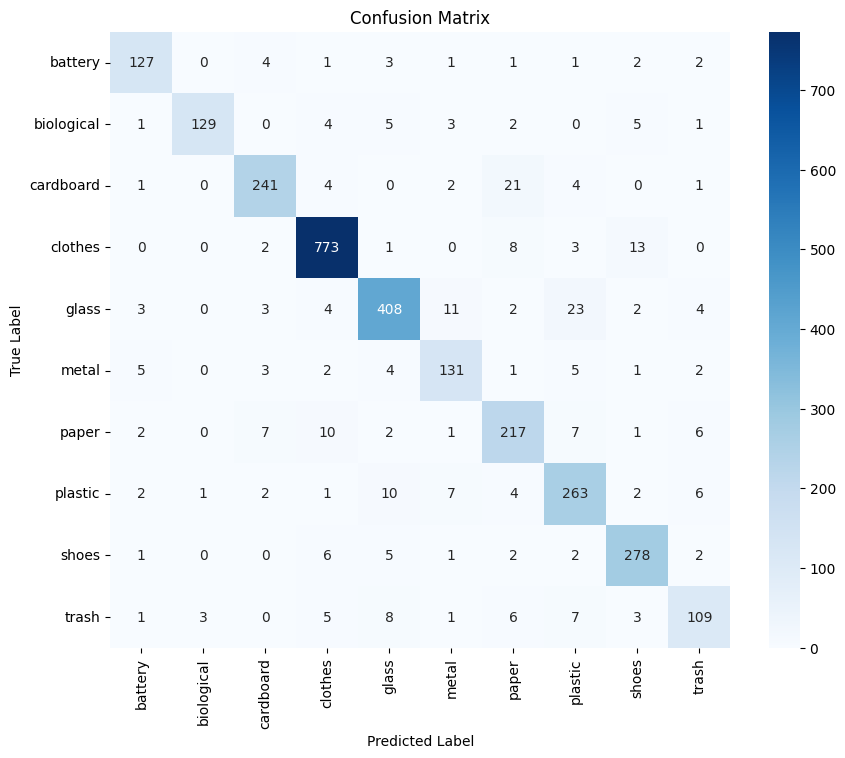

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get true labels & predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)  # Get probability predictions
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices

# Print Classification Report
class_labels = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


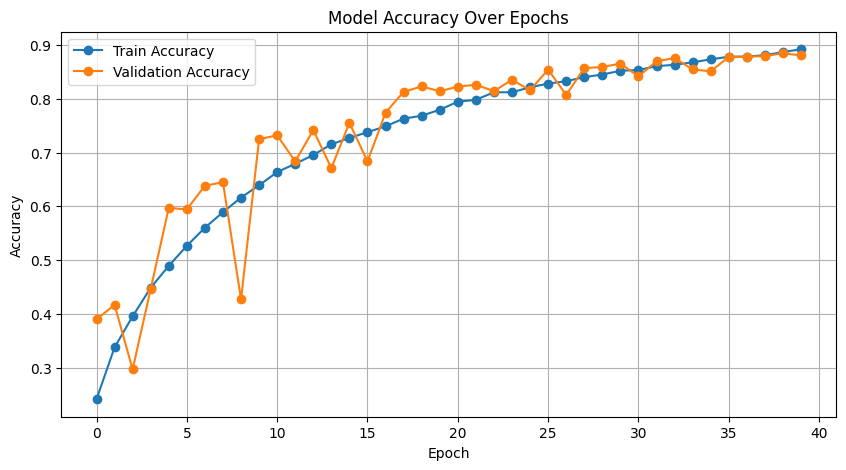

In [19]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


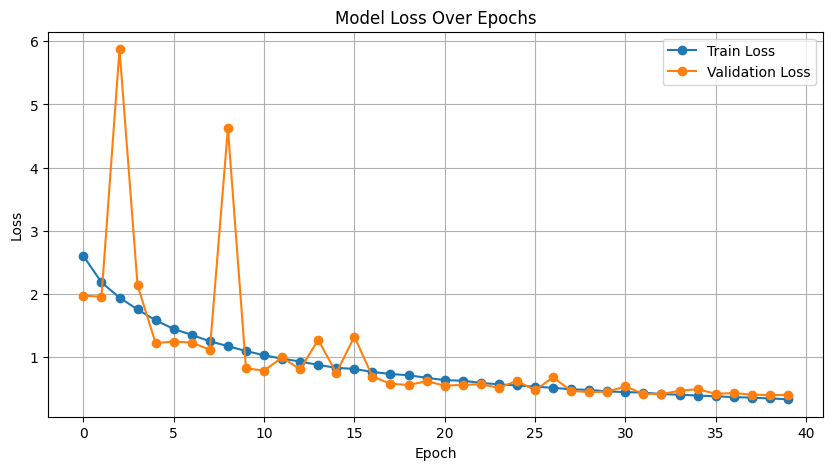

In [20]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_finetune.history['loss'], label='Train Loss', marker='o')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-23-53cd0797ed5c>:10: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


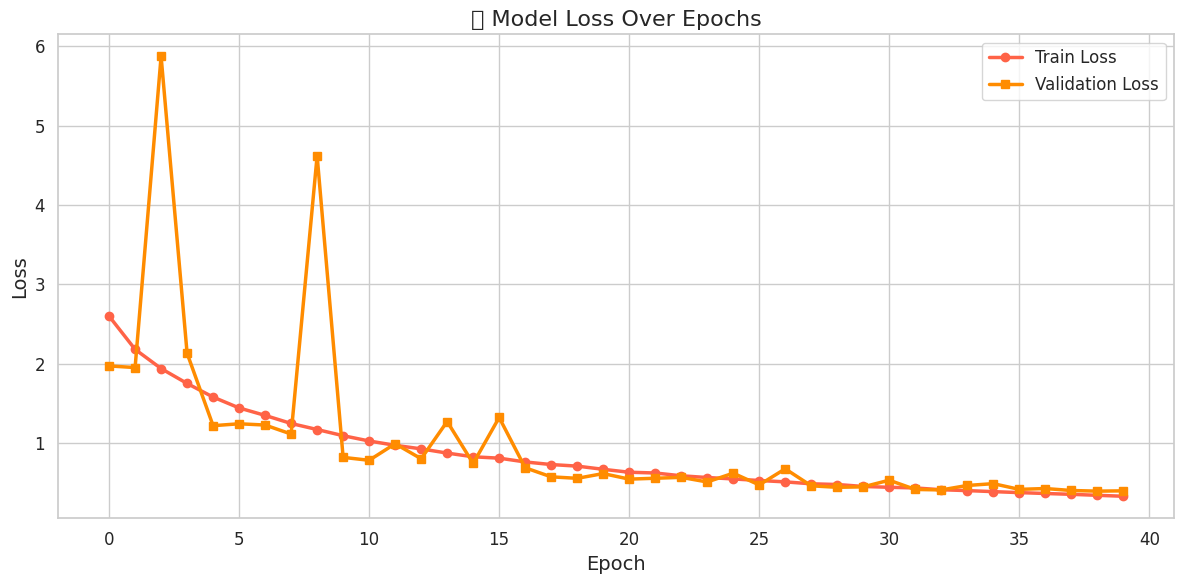

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(history_finetune.history['loss'], label='Train Loss', linewidth=2.5, marker='o', color='tomato')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss', linewidth=2.5, marker='s', color='darkorange')
plt.title('📉 Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek style
sns.set_theme(style="darkgrid", palette="muted")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (12, 6)
})


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

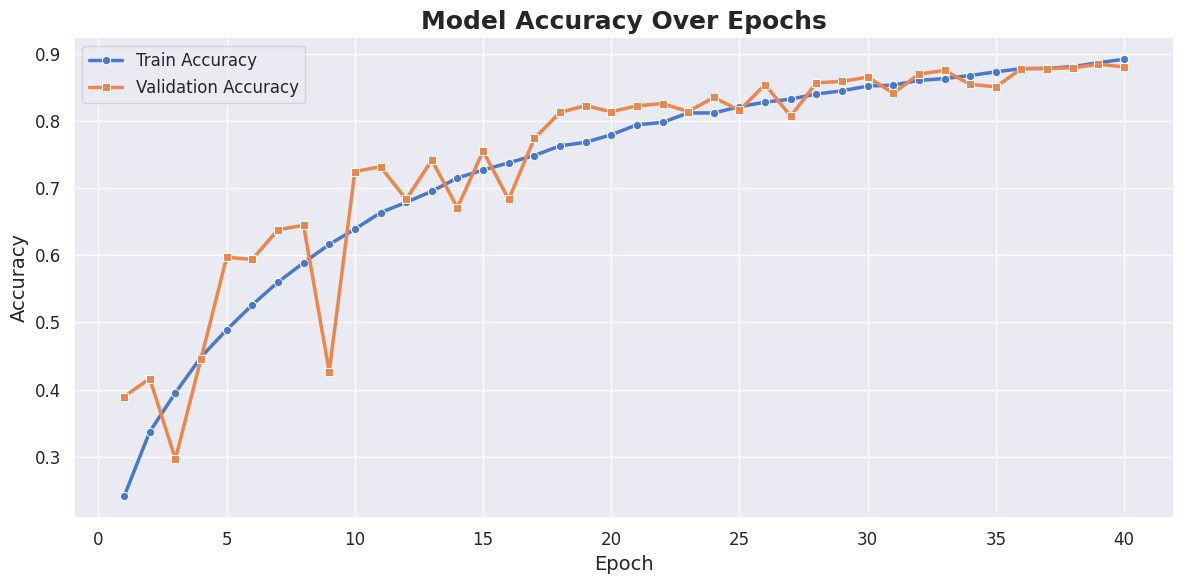

In [25]:
# Plot Accuracy
epochs = range(1, len(history_finetune.history['accuracy']) + 1)
sns.lineplot(x=epochs, y=history_finetune.history['accuracy'], label='Train Accuracy', linewidth=2.5, marker='o')
sns.lineplot(x=epochs, y=history_finetune.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5, marker='s')

plt.title("Model Accuracy Over Epochs", weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

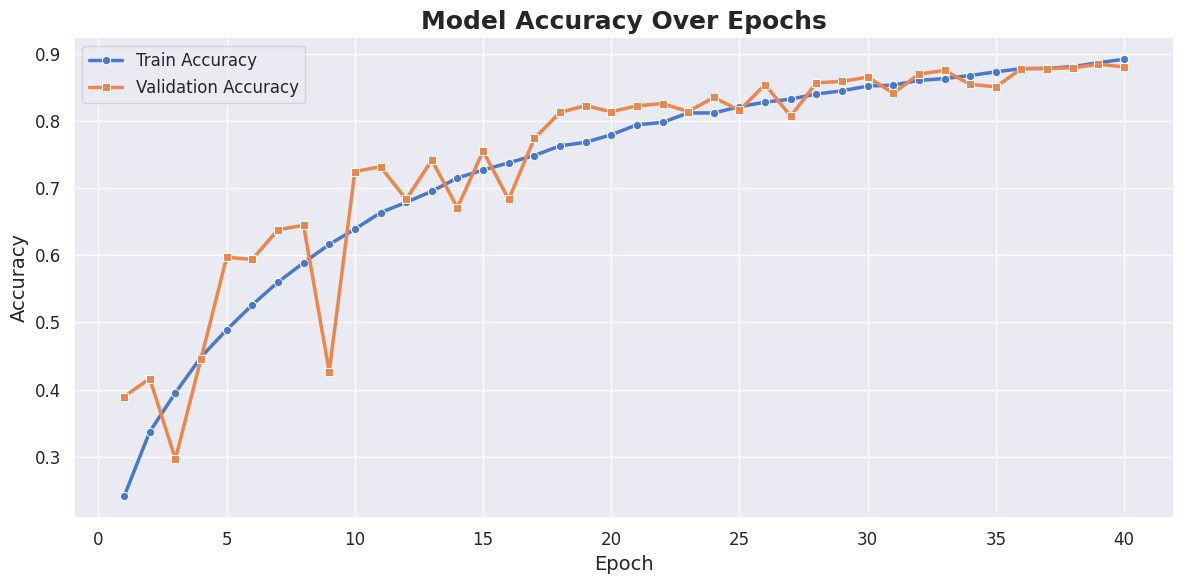

In [26]:
# Plot Accuracy
epochs = range(1, len(history_finetune.history['accuracy']) + 1)
sns.lineplot(x=epochs, y=history_finetune.history['accuracy'], label='Train Accuracy', linewidth=2.5, marker='o')
sns.lineplot(x=epochs, y=history_finetune.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5, marker='s')

plt.title("Model Accuracy Over Epochs", weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

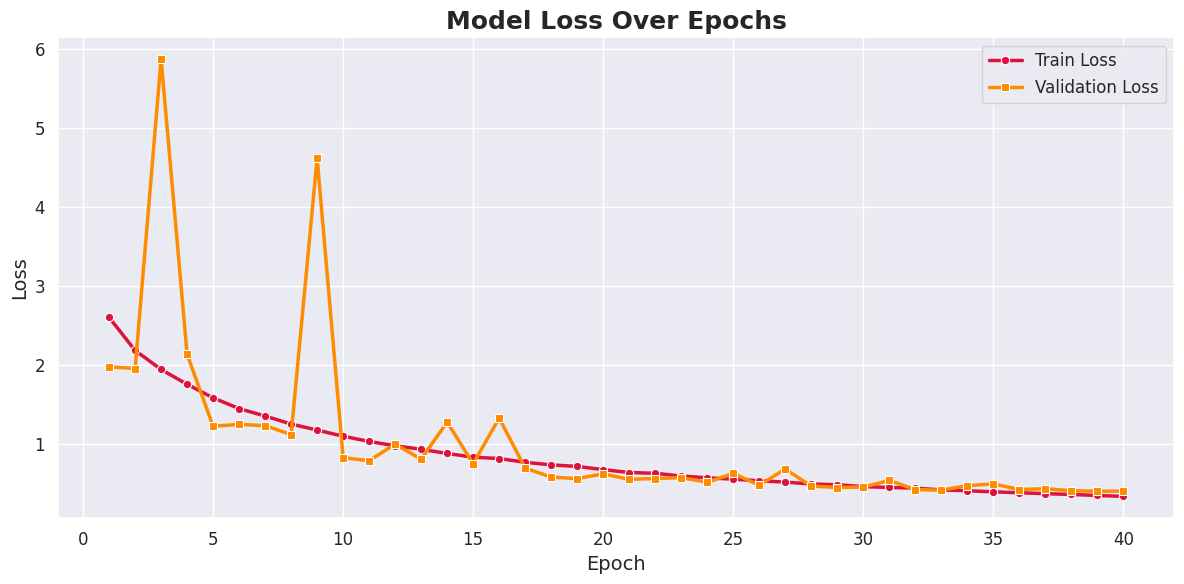

In [27]:
# Plot Loss
sns.lineplot(x=epochs, y=history_finetune.history['loss'], label='Train Loss', linewidth=2.5, marker='o', color="crimson")
sns.lineplot(x=epochs, y=history_finetune.history['val_loss'], label='Validation Loss', linewidth=2.5, marker='s', color="darkorange")

plt.title("Model Loss Over Epochs", weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
# Save the final trained model
model.save("mini1_waste_classification_model.keras")
print("Model saved successfully!")


Model saved successfully!


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import json

# Load the trained classification model
classification_model = load_model("mini1_waste_classification_model.keras")

# Define specific recycling methods as metadata
recycling_methods = {
    "battery": "Extract metals & chemicals, recycle at battery processing centers.",
    "biological": "Composting to produce organic fertilizers.",
    "cardboard": "Shredding & pulping to make new paper products.",
    "clothes": "Fiber recovery for new textiles or insulation materials.",
    "glass": "Melting & remolding into new glass products.",
    "metal": "Melting & reshaping into new metal items.",
    "paper": "Pulping & remanufacturing into recycled paper products.",
    "plastic": "Shredding, melting & remolding into new plastic products.",
    "shoes": "Grinding materials for use in new footwear or rubber products.",
    "trash": "Incineration for energy recovery or landfill disposal."
}

# Convert recycling methods to JSON format and store as metadata
classification_model.metadata = {
    "recycling_methods": json.dumps(recycling_methods)  # Save as JSON string
}

# Save the updated model as a single .keras file
classification_model.save("mini1_waste_classification_recycling.keras")

print("✅ Model saved successfully as 'mini1_waste_classification_recycling.keras'.")


✅ Model saved successfully as 'mini1_waste_classification_recycling.keras'.


In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import json

# Load the model
model = load_model("mini1_waste_classification_recycling.keras")

# Class labels (same order as used during training)
class_labels = ['battery', 'biological', 'cardboard', 'clothes', 'glass',
                'metal', 'paper', 'plastic', 'shoes', 'trash']

# Recycling methods (manually defined here)
recycling_methods = {
    "battery": "Extract metals & chemicals, recycle at battery processing centers.",
    "biological": "Composting to produce organic fertilizers.",
    "cardboard": "Shredding & pulping to make new paper products.",
    "clothes": "Fiber recovery for new textiles or insulation materials.",
    "glass": "Melting & remolding into new glass products.",
    "metal": "Melting & reshaping into new metal items.",
    "paper": "Pulping & remanufacturing into recycled paper products.",
    "plastic": "Shredding, melting & remolding into new plastic products.",
    "shoes": "Grinding materials for use in new footwear or rubber products.",
    "trash": "Incineration for energy recovery or landfill disposal."
}

# Function to classify image and suggest recycling method
def classify_and_get_recycling(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    # Get results
    predicted_label = class_labels[predicted_class]
    recycling_method = recycling_methods.get(predicted_label, "No info available.")

    # Output
    print(f"🗂️ Predicted Category: {predicted_label}")
    print(f"✅ Confidence: {confidence:.4f}")
    print(f"♻️ Suggested Recycling Method: {recycling_method}")

# 🔍 Example test
img_path = "/kaggle/input/examples/example1.jpg"  # Change to your test image
classify_and_get_recycling(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🗂️ Predicted Category: cardboard
✅ Confidence: 0.9999
♻️ Suggested Recycling Method: Shredding & pulping to make new paper products.


In [39]:
# Save your trained model
model.save("mini1_waste_classification_model.keras")
print("✅ Model saved as 'mini1_waste_classification_model.keras'")


✅ Model saved as 'mini1_waste_classification_model.keras'


In [46]:
import json

# Ensure you're referencing the trained model
model = classification_model  # or replace with your actual trained model name

# Save the model
model.save("MINI_FINAL.keras")

# Save recycling methods to JSON
recycling_methods = {
    "battery": "Extract metals & chemicals, recycle at battery processing centers.",
    "biological": "Composting to produce organic fertilizers.",
    "cardboard": "Shredding & pulping to make new paper products.",
    "clothes": "Fiber recovery for new textiles or insulation materials.",
    "glass": "Melting & remolding into new glass products.",
    "metal": "Melting & reshaping into new metal items.",
    "paper": "Pulping & remanufacturing into recycled paper products.",
    "plastic": "Shredding, melting & remolding into new plastic products.",
    "shoes": "Grinding materials for use in new footwear or rubber products.",
    "trash": "Incineration for energy recovery or landfill disposal."
}

# Save to JSON
with open("recycling_methods.json", "w") as f:
    json.dump(recycling_methods, f)

print("✅ Model and metadata saved successfully.")


✅ Model and metadata saved successfully.


In [47]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import json

# Load trained model
model = load_model("mini1_waste_classification_model.keras")

# Load recycling methods
with open("recycling_methods.json", "r") as f:
    recycling_methods = json.load(f)

# Class labels (in the same order used during training)
class_labels = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 
                'metal', 'paper', 'plastic', 'shoes', 'trash']

# Prediction function
def classify_and_get_recycling(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    # Get class name and recycling method
    predicted_category = class_labels[predicted_class]
    recycling_method = recycling_methods.get(predicted_category, "No recycling method available.")

    # Output
    print(f"🗂️ Predicted Waste Category: {predicted_category}")
    print(f"✅ Confidence: {confidence:.4f}")
    print(f"♻️ Recycling Method: {recycling_method}")

# 🔍 Example usage — change path to your test image
test_image_path = "/kaggle/input/examples/example2.jpg"  # replace with real path
classify_and_get_recycling(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🗂️ Predicted Waste Category: metal
✅ Confidence: 0.9161
♻️ Recycling Method: Melting & reshaping into new metal items.


In [48]:
test_image_path = "/kaggle/input/examples/example3.jpg"  # replace with real path
classify_and_get_recycling(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
🗂️ Predicted Waste Category: plastic
✅ Confidence: 0.9997
♻️ Recycling Method: Shredding, melting & remolding into new plastic products.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


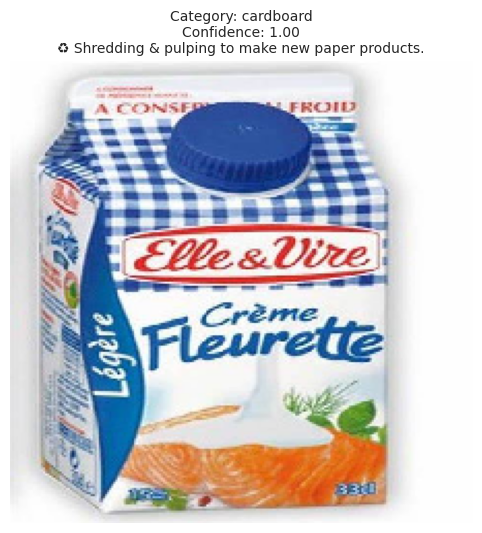

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import json

# Load trained model
model = load_model("MINI_FINAL.keras")

# Load recycling methods
with open("recycling_methods.json", "r") as f:
    recycling_methods = json.load(f)

# Class labels
class_labels = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 
                'metal', 'paper', 'plastic', 'shoes', 'trash']

# Function to predict and display
def classify_and_get_recycling(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Predict class
    prediction = model.predict(img_array_expanded)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    # Get class label and method
    predicted_category = class_labels[predicted_class]
    recycling_method = recycling_methods.get(predicted_category, "No recycling method available.")

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Category: {predicted_category}\nConfidence: {confidence:.2f}\n♻️ {recycling_method}", fontsize=10)
    plt.show()

# 🔍 Example usage — change path to your test image
test_image_path = "/kaggle/input/examples/example1.jpg"  # Replace with actual image path
classify_and_get_recycling(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


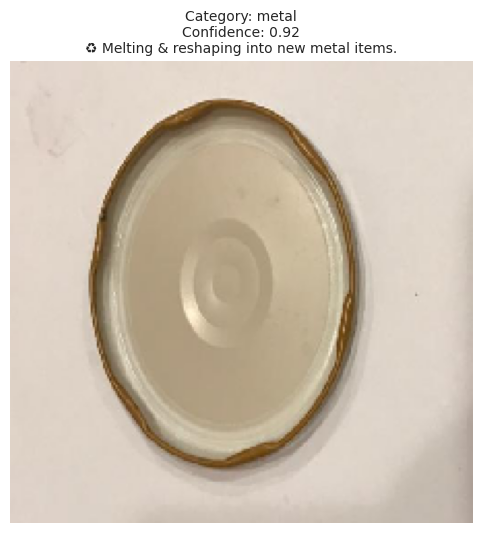

In [50]:
test_image_path = "/kaggle/input/examples/example2.jpg"  # Replace with actual image path
classify_and_get_recycling(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


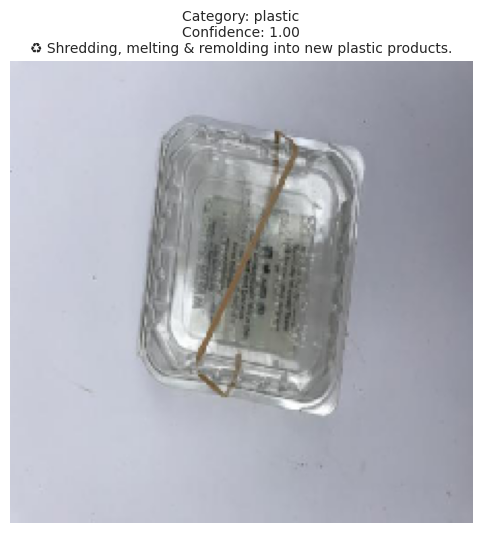

In [51]:
test_image_path = "/kaggle/input/examples/example3.jpg"  # Replace with actual image path
classify_and_get_recycling(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


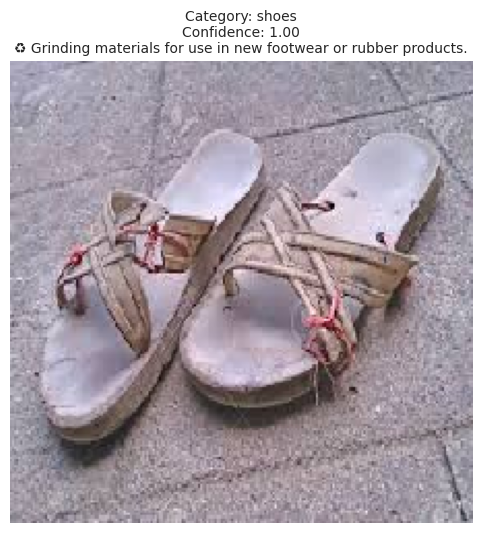

In [52]:
test_image_path = "/kaggle/input/examples/example4.jpg"  # Replace with actual image path
classify_and_get_recycling(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


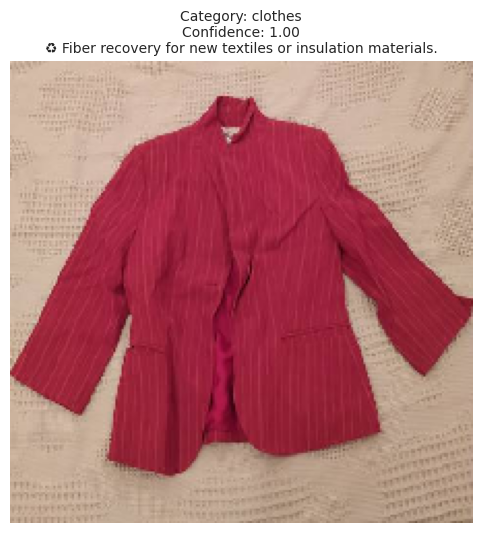

In [53]:
test_image_path = "/kaggle/input/examples/example5.jpg"  # Replace with actual image path
classify_and_get_recycling(test_image_path)